<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
df_final_train.head(1)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,11,15,6,8,0,0,0.0,...,0.000002,1.545089e-13,8.108439e-13,1.719704e-14,-1.355369e-12,4.675320e-13,0.000001,6.616716e-14,9.771079e-13,4.160012e-14


Preferential Attachement

In [ ]:
def pre(dt):
  pref_followers = []
  pref_followees = []
  pref_followers = dt['num_followers_s'] * dt['num_followers_d']
  pref_followees = dt['num_followees_s'] * dt['num_followees_d']
  return pref_followers,pref_followees


In [ ]:
df_final_train['preferential_attach_followers'], df_final_train['preferential_attach_followees'] = pre(df_final_train)
df_final_test['preferential_attach_followers'], df_final_test['preferential_attach_followees'] = pre(df_final_test)



In [ ]:
df_final_train.shape

(100002, 53)

In [ ]:
df_final_test.shape

(24932, 53)

Adding the svd features for the dot product

In [ ]:
if os.path.isfile('/content/train_pos_after_eda.csv'):
  train_graph = nx.read_edgelist('/content/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(train_graph))
  

DiGraph with 1780722 nodes and 7550015 edges


In [ ]:
train_graph

In [ ]:
def svd(x,S):
  try:
    z=sadj_dict[x]
    return S[z]
  except:
    return [0,0,0,0,0,0]

In [ ]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = {val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
U,s,V = svds(Adj, k=6)
print('U',U.shape)
print('V',V.shape)
print('s',s.shape)
print('Adjacent matrix shape',Adj.shape)

U (1780722, 6)
V (6, 1780722)
s (6,)
Adjacent matrix shape (1780722, 1780722)


In [ ]:
def svd_dot(df):
  dot_v = []
  dot_u = []
  for i,row in df.iterrows():
    a1 = svd(row['source_node'],U)
    b1 = svd(row['destination_node'],U)
    dot_u.append(np.dot(a1,b1))
    a2 = svd(row['source_node'],V.T)
    b2 = svd(row['destination_node'],V.T)
    dot_v.append(np.dot(a2,b2))
  return dot_u,dot_v

In [ ]:
df_final_train['svd_dot_u'],df_final_train['svd_dot_v'] = svd_dot(df_final_train)
df_final_test['svd_dot_u'],df_final_test['svd_dot_v'] = svd_dot(df_final_test)


In [ ]:
df_final_train.columns #computed features

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attach_followers', 'preferential_attach_followees',
       'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [ ]:
df_final_train.head(1)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers,preferential_attach_followees,svd_dot_u,svd_dot_v
0,273084,1505602,1,11,15,6,8,0,0,0.0,...,-1.355369e-12,4.675320e-13,0.000001,6.616716e-14,9.771079e-13,4.160012e-14,165,48,1.114951e-11,2.238777e-12


In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Random forest classifier w/o svd_features and prefrential attachment

Estimators =  10 Train Score 0.9194183738164282 test Score 0.8797080672487945
Estimators =  50 Train Score 0.9217992652279954 test Score 0.8952559088590374
Estimators =  100 Train Score 0.9221708555131123 test Score 0.9090603321421065
Estimators =  250 Train Score 0.9250553040170356 test Score 0.9078212290502793
Estimators =  450 Train Score 0.9250012921900036 test Score 0.9048548633508741


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

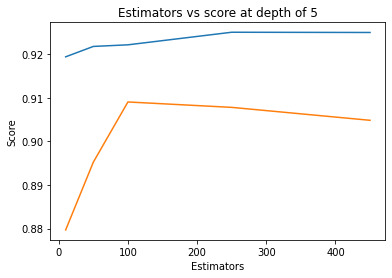

In [ ]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8839327009054749 test Score 0.846556757685042
depth =  9 Train Score 0.9381170535852165 test Score 0.9151751632878107
depth =  11 Train Score 0.9452365554973876 test Score 0.8956167706167706
depth =  15 Train Score 0.9502261519455193 test Score 0.8926480156148341
depth =  20 Train Score 0.9509415465054533 test Score 0.8966173544424259
depth =  35 Train Score 0.9511584923771303 test Score 0.8962799359057643
depth =  50 Train Score 0.9511584923771303 test Score 0.8962799359057643
depth =  70 Train Score 0.9511584923771303 test Score 0.8962799359057643
depth =  130 Train Score 0.9511584923771303 test Score 0.8962799359057643


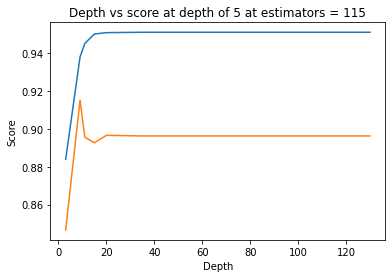

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score = True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.9477661  0.94766867 0.94338025 0.94735715 0.95111456]
mean train scores [0.94964853 0.94955411 0.94507879 0.94927344 0.95352101]


In [ ]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9543035419342999
Test f1 score 0.9097599589234522


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


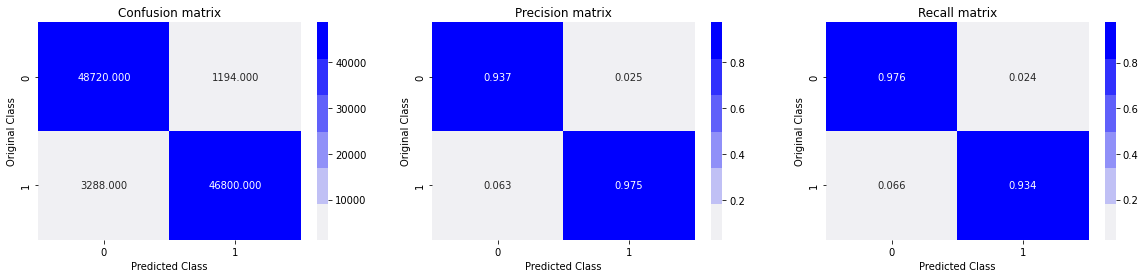

Test confusion_matrix


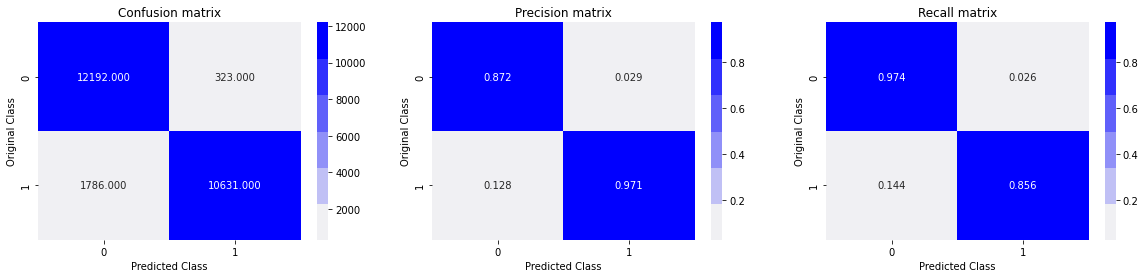

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

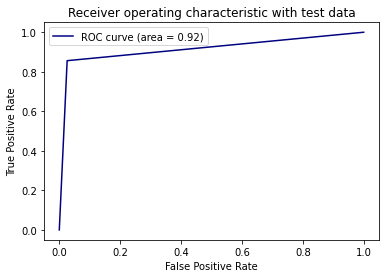

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

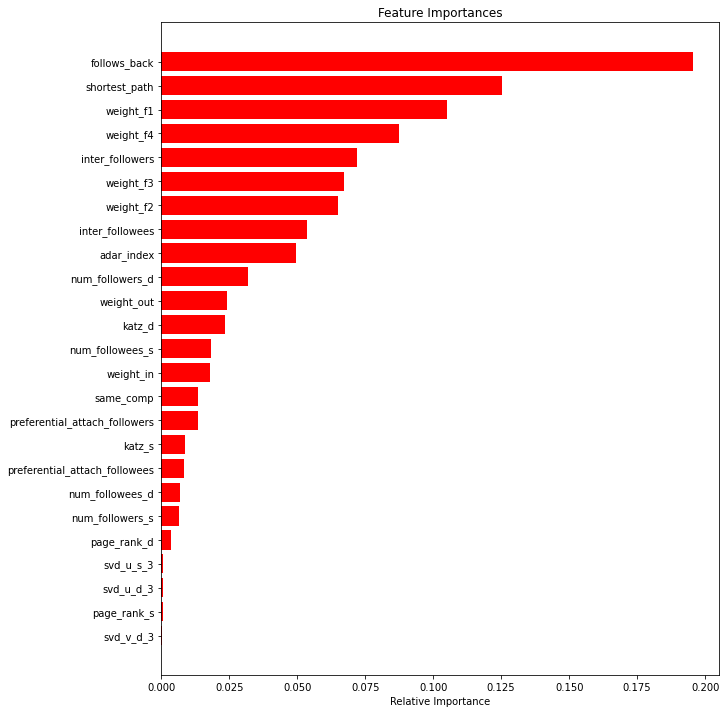

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [ ]:
df_final_train.head(1)

,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attach_followers,preferential_attach_followees,svd_dot_u,svd_dot_v
0,11,15,6,8,0,0,0.0,0,1,4,...,-1.355369e-12,4.675320e-13,0.000001,6.616716e-14,9.771079e-13,4.160012e-14,165,48,1.114951e-11,2.238777e-12


In [ ]:
from xgboost import XGBClassifier 

In [ ]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []

for i in estimators:
  clf = XGBClassifier(n_estimators = i,max_depth=5,n_jobs=-1,verbosity=0)
  clf.fit(df_final_train,y_train)
  train_sc = f1_score(y_train,clf.predict(df_final_train))
  test_sc = f1_score(y_test,clf.predict(df_final_test))
  train_scores.append(train_sc)
  test_scores.append(test_sc)
  print('estimator =',i,"train_score=",train_sc,"test_score=",test_sc)

estimator = 10 train_score= 0.9488784396765588 test_score= 0.9276825043835264
estimator = 50 train_score= 0.9686524519822266 test_score= 0.9321428571428572
estimator = 100 train_score= 0.9753243603734691 test_score= 0.9314672225294592
estimator = 250 train_score= 0.9773794022348059 test_score= 0.9151297887962683
estimator = 450 train_score= 0.9773794022348059 test_score= 0.9128364926858825


Text(0.5, 1.0, 'estimators vs score at depth of 5')

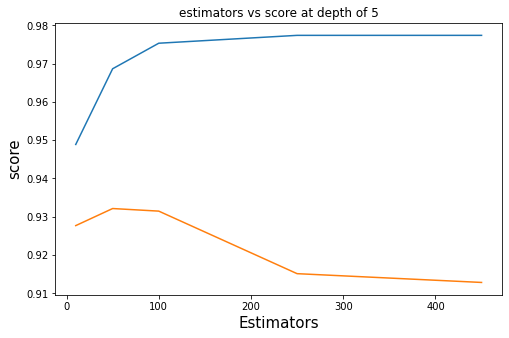

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators',size=15)
plt.ylabel('score',size=15)
plt.title('estimators vs score at depth of 5')


XGB with depth

In [ ]:
depth = [3,9,11,15,20,35,50,70,130]
train_scores1 = []
test_scores1 = []

for i in depth:
  clf = XGBClassifier(max_depth = i,estimators=115,n_jobs=-1,verbosity=0)
  clf.fit(df_final_train,y_train)
  train_sc = f1_score(y_train,clf.predict(df_final_train))
  test_sc = f1_score(y_test,clf.predict(df_final_test))
  train_scores1.append(train_sc)
  test_scores1.append(test_sc)
  print('depth =',i,"train_score=",train_sc,"test_score=",test_sc)

depth = 3 train_score= 0.971731807297374 test_score= 0.9309199318568995
depth = 9 train_score= 0.9844636747836587 test_score= 0.9325450833616877
depth = 11 train_score= 0.9923394697790077 test_score= 0.931733060946544
depth = 15 train_score= 0.99767025627181 test_score= 0.9315872273481015
depth = 20 train_score= 0.9999900176687264 test_score= 0.9322055510689846
depth = 35 train_score= 0.9999900176687264 test_score= 0.9325852248576043
depth = 50 train_score= 0.9999900176687264 test_score= 0.9321089997024189
depth = 70 train_score= 0.9999900176687264 test_score= 0.9321089997024189
depth = 130 train_score= 0.9999900176687264 test_score= 0.9321089997024189


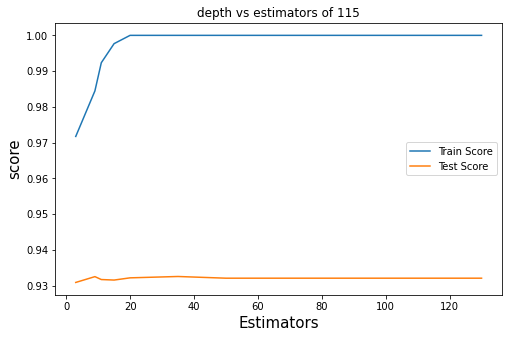

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(depth,train_scores1,label='Train Score')
plt.plot(depth,test_scores1,label='Test Score')
plt.xlabel('Estimators',size=15)
plt.ylabel('score',size=15)
plt.title('depth vs estimators of 115')
plt.legend()

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "learning_rate":[0.1,0.01,0.001]}

clf = XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score = True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97865581 0.97467795 0.97146661 0.97430906 0.97397174]
mean train scores [0.99112251 0.98795072 0.97580649 0.98741443 0.984811  ]


In [ ]:
print(rf_random.best_estimator_)

XGBClassifier(max_depth=12, n_estimators=120, n_jobs=-1, random_state=25)


In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
print("train f1 score",f1_score(y_train,y_train_pred))
print("test f1 score",f1_score(y_test,y_test_pred))


train f1 score 0.971731807297374
test f1 score 0.9309199318568995


In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_pred):
    C = confusion_matrix(y, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(15,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


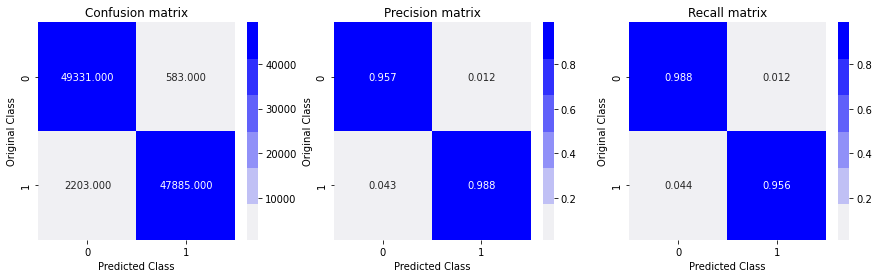

Test confusion_matrix


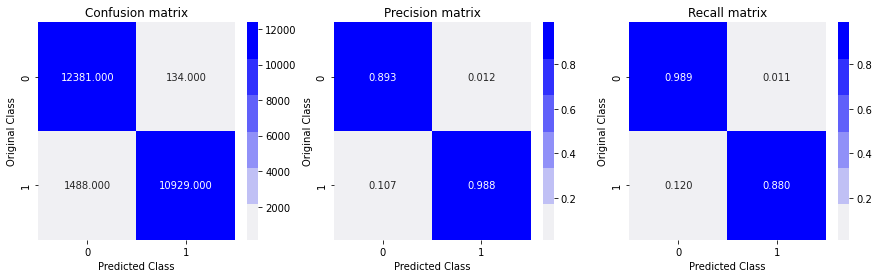

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

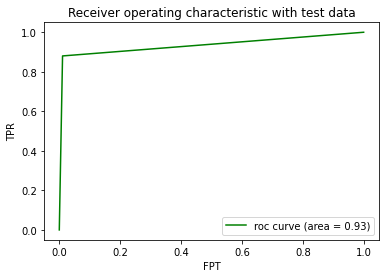

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',label='roc curve (area = %0.2f)' % auc_sc)
plt.xlabel('FPT')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

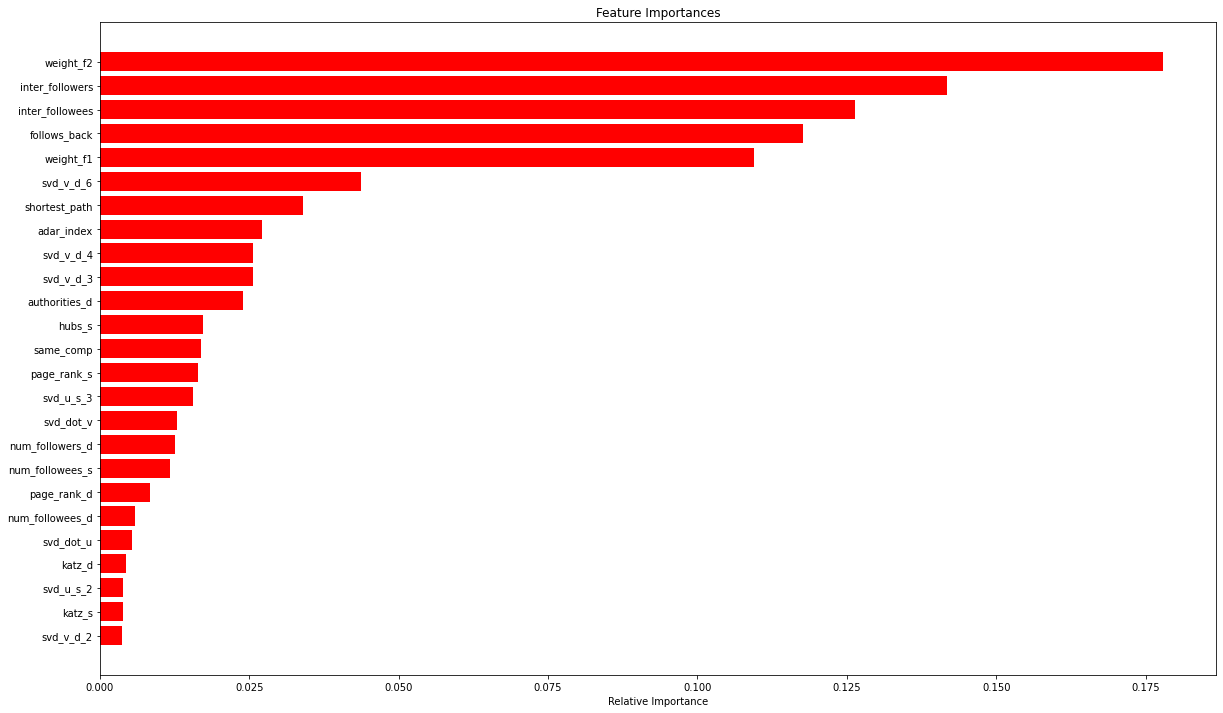

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



*   weightf2 and inter followers has high feature importance
*   least is svd_v_d_2 and similarly kats_s,svd_u_s_2 has less importance



Step 1 : Used the given Storagesamplestage4.h5 and their is no num_followers_destination, so as mentioned i have computed all the features from scratch using fb_featuration

step 2 : after featurization i have created, added new features into dataset which is preferential attachment and svd_dot

step 3 : after that dropping the features which are not useful for classification.

step 4 : Applying XGBClassifier on all the features for classification to check the error metrics.

step 5 : Then first trained the model with depth and n_estimators at 5 then trained a new model with depth and estimator 115 and plotted a graph as n_estimators vs depth 5 and for the second trained model we can observe the above plot as no_of_estimator increases then train score increases but test score decreases and we can see in the above plots as no_of_depths increases but train,test score increases but kept constant from certain depth.

step 6 : then apply randomsearchcv for finding the bestdpeth and best estimator and now fit the model then predict and f1_score and plotted the confusion,precision and recall matrix's

step 7 : after all that plotted the graph for feature importance.

In [ ]:
from prettytable import PrettyTable

tab = PrettyTable(['model','max_depth','n_estimators','train_f1_score','test_f1_score'])
tab.add_row(('XGBClassifier',12,120,0.971,0.930))
tab.add_row(('randomforestclassifier',14,121,0.951,0.923))

In [55]:
print(tab)

+------------------------+-----------+--------------+----------------+---------------+
|         model          | max_depth | n_estimators | train_f1_score | test_f1_score |
+------------------------+-----------+--------------+----------------+---------------+
|     XGBClassifier      |     12    |     120      |     0.971      |      0.93     |
| randomforestclassifier |     14    |     121      |     0.951      |     0.923     |
+------------------------+-----------+--------------+----------------+---------------+
